In [9]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sys
sys.path.append("..")
from src.audio.utils import plot_waveform

In [10]:
full_word = "../data/pronunciation/pronunciation_full.wav"

In [11]:
audio, sr = sf.read(full_word)
audio,sr

(array([0., 0., 0., ..., 0., 0., 0.], shape=(48811,)), 16000)

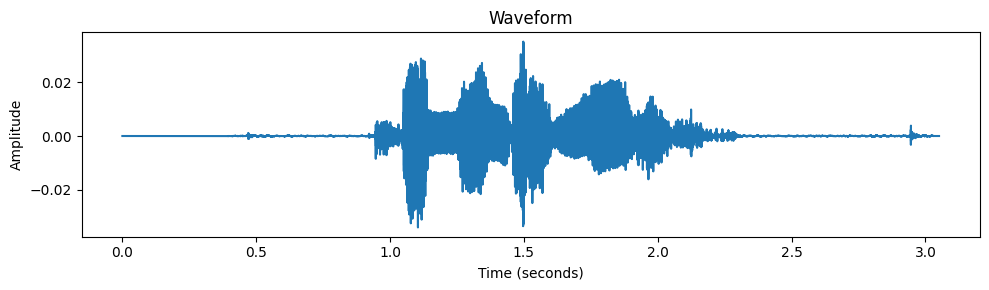

In [13]:
plot_waveform(audio,sr)

In [7]:
audio_trim, _ = librosa.effects.trim(audio, top_db=30)

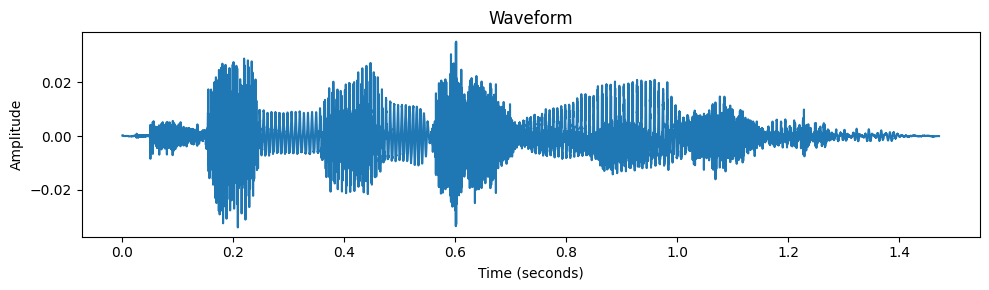

In [14]:
plot_waveform(audio_trim,sr)